# Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import time
import json
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
from xskillscore import crps_quadrature, crps_ensemble

import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))
from modules.architectures import *

from modules.swag import data, models, utils, losses
from modules.swag.posteriors import SWAG

import modules.architectures as modelArchitectures
from modules.full_pipeline import compute_errors, _inner
from modules.plotting import plot_intervalmap, plot_signal
from modules.data import hp_to_equiangular
from modules.test import compute_rmse_healpix, compute_R2

# Config

In [3]:
config_file = 'config_s01_two_steps_small.json'
ep = 11
lead_time = 6

# load config
with open("../configs/" + config_file) as json_data_file:
    cfg = json.load(json_data_file)

# define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

# model parameters
max_lead_time = cfg['training_constants']['max_lead_time']
len_sqce = cfg['model_parameters']['len_sqce']
delta_t = cfg['model_parameters']['delta_t']
architecture_name = cfg['model_parameters']['architecture_name']
resolution = cfg['model_parameters']['resolution']

# CRPSS

## Load already computed CRPS for each model

In [4]:
description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name
descriptions = [
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale001',
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale01',
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale03',
    description_epoch + '_s02_ensemble_epoch_11',
    description_epoch + f'_s02_fixed_data_ensemble_ensemble_epoch_11',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale00',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01'
]

labels = [
    'SWAG Scale 0.01',
    'SWAG Scale 0.1',
    'SWAG Scale 0.3',
    'Deep Ensemble',
    'Deep Ensemble Fixed Training Set',
    'MultiSWA',
    'MultiSWAG Scale 0.1'
]

file_paths = []

for description in descriptions:
    crps_filename = datadir + 'metrics/crps_' + description + '.nc'    
    file_paths.append(crps_filename)

crps_list = []
    
for path in file_paths:
    crps = xr.open_dataset(path)
    crps_list.append(crps)

## Compute reference CRPS

In [5]:
compute = False

In [6]:
def to_equi(data):
    data_equi = []
    for lead_time in data.lead_time.values:
        print("Lead time :", lead_time)
        intermediate = data.sel(lead_time=lead_time)
        data_time = []
        for time in data.time.values:
            data_inter = hp_to_equiangular(intermediate.sel(time=time), resolution)
            data_time.append(data_inter)
            
        data_time = xr.concat(data_time, dim='time')
        data_time['time'] = data.time.values
        data_equi.append(data_time)
    
    data_equi =  xr.concat(data_equi, dim="lead_time")
    data_equi['lead_time'] = data.lead_time.values
    
    return data_equi

In [7]:
if compute:
    obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords')
    obs_equi = to_equi(obs)
    obs_equi.to_netcdf(pred_save_path + 'observations_equi.nc')

In [8]:
# Load observations in equiangular
obs_equi = xr.open_dataset(pred_save_path + 'observations_equi.nc')

### Climatology

In [9]:
climatology = xr.open_dataset("../data/models/baselines/weekly_climatology_5.625.nc").drop('level').drop('week')
climatology = climatology[['z', 't']]
climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 ...
    t        (time, lat, lon) float32 ...

In [10]:
def create_clim_forecast(ds, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    ds_fc = ds.isel(time=slice(0, -lead_time_h))
    return ds_fc

lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)}, name='lead_time')

climatology_ds = []
for l in lead_times:
    climatology_ds.append(create_clim_forecast(climatology, int(l)))
climatology_ds = xr.concat(climatology_ds, dim=lead_times)

climatology_ds

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 20, lon: 64, time: 17514)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z          (lead_time, time, lat, lon) float32 50208.12 50222.945 ... nan
    t          (lead_time, time, lat, lon) float32 256.2407 256.28226 ... nan

In [11]:
# Get common time and lead time
common_time = list(set(climatology_ds.time.values).intersection(obs_equi.time.values))
common_time.sort()

common_lead_time = list(set(climatology_ds.lead_time.values).intersection(obs_equi.lead_time.values))
common_lead_time.sort()

climatology_ds = climatology_ds.sel(dict(time=common_time, lead_time=common_lead_time))
obs_equi = obs_equi.sel(dict(time=common_time, lead_time=common_lead_time)).load()

In [12]:
if compute:
    climatology_ds = xr.concat([climatology_ds], dim='member')
    
    dims = list(climatology_ds.dims).copy()
    dims.remove('member')
    dims.remove('lead_time')
    
    crps_climatology = crps_ensemble(obs_equi, climatology_ds, dim=dims).compute()
    crps_climatology.to_netcdf(datadir + 'metrics/crps_climatology.nc')
else:
    crps_climatology = xr.open_dataset(datadir + 'metrics/crps_climatology.nc')

### Persistence

In [13]:
persistence = xr.open_dataset("../data/models/baselines/persistence_5.625.nc")
persistence = persistence[['z', 't']]
persistence

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 20, lon: 64, time: 17514)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z          (lead_time, time, lat, lon) float32 ...
    t          (lead_time, time, lat, lon) float32 ...

In [14]:
common_time = list(set(persistence.time.values).intersection(obs_equi.time.values))
common_time.sort()

common_lead_time = list(set(persistence.lead_time.values).intersection(obs_equi.lead_time.values))
common_lead_time.sort()

persistence = persistence.sel(dict(time=common_time, lead_time=common_lead_time))
obs_equi = obs_equi.sel(dict(time=common_time, lead_time=common_lead_time)).load()

In [15]:
if compute:
    persistence = xr.concat([persistence], dim='member')
    
    dims = list(persistence.dims).copy()
    dims.remove('member')
    dims.remove('lead_time')
    
    crps_persistence = crps_ensemble(obs_equi, persistence, dim=dims).compute()
    crps_persistence.to_netcdf(datadir + 'metrics/crps_persistence.nc')
else:
    crps_persistence = xr.open_dataset(datadir + 'metrics/crps_persistence.nc')

## Compute CRPSS for each model and plot

In [16]:
# Compute CRPSS
crpss_list = []
for crps in crps_list:
    curr = 1 - (crps/crps_persistence)
    crpss_list.append(curr)

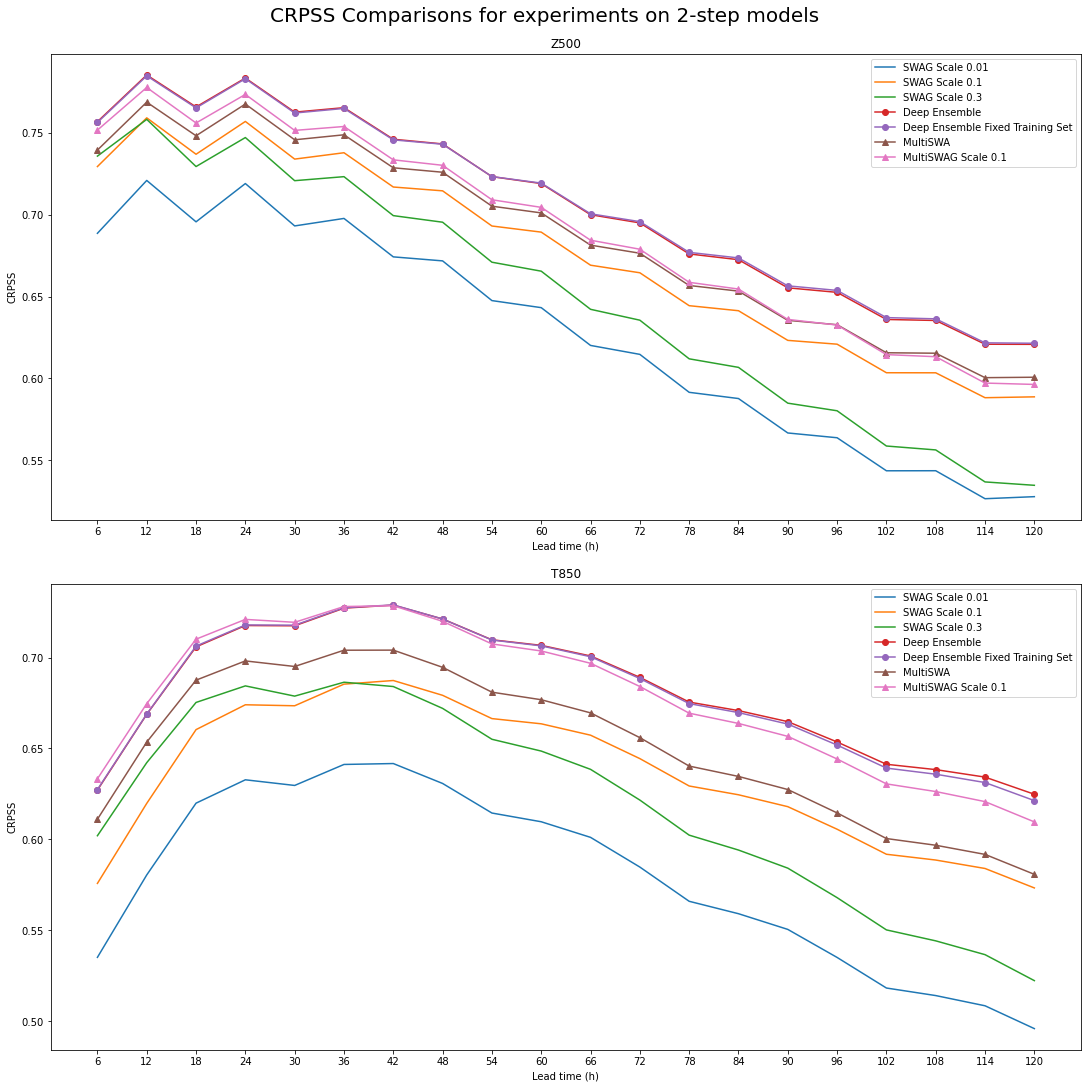

In [17]:
labels = [
    'SWAG Scale 0.01',
    'SWAG Scale 0.1',
    'SWAG Scale 0.3',
    'Deep Ensemble',
    'Deep Ensemble Fixed Training Set',
    'MultiSWA',
    'MultiSWAG Scale 0.1'
]

markers = ['', '', '', 'o', 'o', '^', '^']

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)
    
lead_times = np.arange(lead_time, max_lead_time + lead_time, lead_time)

for i, crpss in enumerate(crpss_list):
    ax1.plot(lead_times, crpss.z.values, label=labels[i], marker=markers[i])
    
for i, crpss in enumerate(crpss_list):
    ax2.plot(lead_times, crpss.t.values, label=labels[i], marker=markers[i])

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('CRPSS')
ax2.set_ylabel('CRPSS')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('CRPSS Comparisons for experiments on 2-step models', fontsize=20)
ax1.legend()
ax2.legend()
plt.show()

# CRPSS Map

## Reference CRPS Maps

In [18]:
compute = False

### Climatology

In [19]:
if compute:
    climatology_ds = xr.concat([climatology_ds], dim='member')

    crps_climatology_map = crps_ensemble(obs_equi, climatology_ds, dim=('time')).compute()
    crps_climatology_map.to_netcdf(datadir + 'metrics/crps_map_climatology.nc')
else:
    crps_climatology_map = xr.open_dataset(datadir + 'metrics/crps_map_climatology.nc')
    
crps_climatology_map

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 20, lon: 64)
Coordinates:
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time, lat, lon) float64 ...
    t          (lead_time, lat, lon) float64 ...

### Persistence

In [20]:
if compute:
    persistence = xr.concat([persistence], dim='member')
    crps_persistence_map = crps_ensemble(obs_equi, persistence, dim=('time')).compute()
    crps_persistence_map.to_netcdf(datadir + 'metrics/crps_map_persistence.nc')
else:
    crps_persistence_map = xr.open_dataset(datadir + 'metrics/crps_map_persistence.nc')

crps_persistence_map

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 20, lon: 64)
Coordinates:
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time, lat, lon) float64 ...
    t          (lead_time, lat, lon) float64 ...

## CRPS Maps of each model

In [21]:
compute = False
compute_swag = True

In [22]:
description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name

description_ens = [
    description_epoch + '_s02_ensemble_model0_epoch11.nc',
    description_epoch + '_s02_fixed_data_ensemble_ensemble_model0_epoch11.nc',
    description_epoch + '_s02_multiswag_ensemble_model0_epoch11_swag_scale00.nc',
    description_epoch + '_s02_multiswag_ensemble_model0_epoch11_swag_scale01_aggregate.nc'
]

description_swag = [
    description_epoch + '_s02_swag_freq10_epoch11_swag_scale001_realization0.nc',
    description_epoch + '_s02_swag_freq10_epoch11_swag_scale01_realization0.nc',
    description_epoch + '_s02_swag_freq10_epoch11_swag_scale03_realization0.nc'
]

In [23]:
if compute:

    obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords')

    crps_maps = []
    for idx, description in enumerate(description_ens):
        print("Model", idx+1)
        ens = []
        description_model = description
        for i in range(10):
            description_model = description_model.replace(f'model{i}', f'model{i+1}')
            pred = xr.open_dataset(pred_save_path + description_model).chunk('auto')
            pred = pred.drop('lat').drop('lon')
            ens.append(pred)

        ens_ds = xr.concat(ens, dim="member")

        common_time = list(set(ens_ds.time.values).intersection(obs.time.values))
        common_time.sort()
        common_lead_time = list(set(ens_ds.lead_time.values).intersection(obs.lead_time.values))
        common_lead_time.sort()
        ens_ds = ens_ds.sel(dict(time=common_time, lead_time=common_lead_time))
        if idx == 0:
            obs = obs.sel(dict(time=common_time, lead_time=common_lead_time))
            obs = obs.chunk(ens[-1].chunks)

        crps_map = crps_ensemble(obs, ens_ds.chunk({'member': -1}), dim=('time')).compute()
        crps_maps.append(crps_map)

        del ens
        del ens_ds

    for i, crps_map in enumerate(crps_maps):
        name = description_ens[i].replace('_model0', '')
        crps_map.to_netcdf(datadir + 'metrics/crps_map_' + name)
else:
    crps_maps = []
    for i, description in enumerate(description_ens):
        name = description.replace('_model0', '')
        crps_map = xr.open_dataset(datadir + 'metrics/crps_map_' + name)
        crps_maps.append(crps_map)

In [ ]:
if compute_swag:
    obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords')
    
    crps_maps_swag = []
    for idx, description in enumerate(description_swag):
        print("Model", idx+1)
        ens = []
        description_model = description
        for i in range(10):
            description_model = description_model.replace(f'realization{i}', f'realization{i+1}')
            pred = xr.open_dataset(pred_save_path + description_model).chunk('auto')
            pred = pred.drop('lat').drop('lon')
            ens.append(pred)

        ens_ds = xr.concat(ens, dim="member")

        common_time = list(set(ens_ds.time.values).intersection(obs.time.values))
        common_time.sort()
        common_lead_time = list(set(ens_ds.lead_time.values).intersection(obs.lead_time.values))
        common_lead_time.sort()
        ens_ds = ens_ds.sel(dict(time=common_time, lead_time=common_lead_time))
        if idx == 0:
            obs = obs.sel(dict(time=common_time, lead_time=common_lead_time))
            obs = obs.chunk(ens[-1].chunks)

        crps_map = crps_ensemble(obs, ens_ds.chunk({'member': -1}), dim=('time')).compute()
        crps_maps_swag.append(crps_map)

        del ens
        del ens_ds
    
    for i, crps_map in enumerate(crps_maps_swag):
        name = description_swag[i].replace('_realization0', '')
        crps_map.to_netcdf(datadir + 'metrics/crps_map_' + name)
else:
    crps_maps_swag = []
    for i, description in enumerate(description_swag):
        name = description.replace('_realization0', '')
        crps_map = xr.open_dataset(datadir + 'metrics/crps_map_' + name)
        crps_maps_swag.append(crps_map)

Model 1


In [ ]:
def to_equi_lead_times(data):
    data_equi = []
    for i in range(len(data.lead_time.values)):
        data_inter = hp_to_equiangular(data.isel(lead_time=i), resolution)
        data_equi.append(data_inter)
    data_equi = xr.concat(data_equi, dim="lead_time")
    data_equi['lead_time'] = data.lead_time.values
    
    return data_equi

In [ ]:
# Compute equiangular version of CRPS maps
crps_maps_equi = []
for crps_map in crps_maps:
    curr = crps_map.drop('lat').drop('lon')
    crps_maps_equi.append(to_equi_lead_times(curr))

crps_maps_swag_equi = []
for crps_map in crps_maps_swag:
    curr = crps_map.drop('lat').drop('lon')
    crps_maps_swag_equi.append(to_equi_lead_times(curr))

In [ ]:
# Compute the CRPSS maps of equiangular CRPS maps
crpss_maps_equi = []
for crps_map in crps_maps_equi:
    curr = 1 - (crps_map/crps_persistence_map)
    crpss_maps_equi.append(curr)

crpss_maps_swag_equi = []
for crps_map in crps_maps_swag_equi:
    curr = 1 - (crps_map/crps_persistence_map)
    crpss_maps_swag_equi.append(curr)

# Find lead times at which the CRPSS is negative

In [ ]:
def get_lead_times(crpss_map):
    lat_lon_z = []
    lat_lon_t = []

    lats = crpss_map.lat.values
    lons = crpss_map.lon.values
    for lat in lats:
        lon_z = []
        lon_t = []
        for lon in lons:
            curr = crpss_map.sel(lat=lat, lon=lon)
            if curr.z.min() < 0:
                z = curr.z.isel(curr.z.argmin(...)).lead_time.item()
            else:
                z = -120
            if curr.t.min() < 0:
                t = curr.t.isel(curr.t.argmin(...)).lead_time.item()
            else:
                t = -120
            lon_z.append(z)
            lon_t.append(t)
        lat_lon_z.append(lon_z)
        lat_lon_t.append(lon_t)

    result_z = xr.DataArray(lat_lon_z, coords=[lats, lons], dims=['lat', 'lon'], name='z')
    result_t = xr.DataArray(lat_lon_t, coords=[lats, lons], dims=['lat', 'lon'], name='t')
    result = xr.merge([result_z, result_t])
    
    return result

In [ ]:
lead_times_map = []
for crpss_map in crpss_maps_equi:
    lead_times_map.append(get_lead_times(crpss_map))

lead_times_swag_map = []
for crpss_map in crpss_maps_swag_equi:
    lead_times_swag_map.append(get_lead_times(crpss_map))

In [ ]:
min_max = [0, 120]

labels = [
    'Deep Ensemble',
    'Deep Ensemble Fixed Training Set',
    'MultiSWA',
    'MultiSWAG Scale 0.1',
    'SWAG Scale 0.01',
    'SWAG Scale 0.1',
    'SWAG Scale 0.3'
]

for i, lt_map in enumerate(lead_times_map + lead_times_swag_map):
    proj = ccrs.PlateCarree()
    f, axs = plt.subplots(1, 2, figsize=(15,15), subplot_kw=dict(projection=proj))

    cols = ['Z500', 'T850']
    for ax, col in zip(axs, cols):
        ax.set_title(col, fontsize=24, y=1.08)

    f.suptitle(f'Map of leadtime hours at which the CRPSS \nbecomes negative for {labels[i]}', 
               fontsize=22, y=0.7, x=0.45)

    plot_signal(f, sample=lt_map, var='z', vmin=min_max[0], vmax=min_max[1], proj=proj, ax=axs[0], 
                cmap='Reds', colorbar=False, cbar_label='', extend='max')
    plot_signal(f, sample=lt_map, var='t', vmin=min_max[0], vmax=min_max[1], proj=proj, ax=axs[1], 
                cmap='Reds', colorbar=True, cbar_label='Lead time', extend='max', cbar_shrink=0.3)

    f.tight_layout(pad=-2)

    plt.show()